<a href="https://colab.research.google.com/github/YazRaso/SecureSwipe/blob/main/churn_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install category_encoders
!pip install scikit-optimize

In [19]:
# Import required modules
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [20]:
# Import dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Initialize dataset
df = pd.read_csv('/content/drive/MyDrive/telcocustomerchurn.csv')

In [22]:
# Pre-process and clean data
# we do not need payment method, total charges, contract, customerID
cols_to_drop = ['PaymentMethod', 'TotalCharges', 'Contract', 'customerID',
                'gender', 'PaperlessBilling', 'Partner', 'MultipleLines', 'InternetService'
]

df = df.drop(columns=cols_to_drop)


In [23]:
# Convert all boolean values to 1s and 0s, where 1 is Yes and 0 is No
# this is necessary for the model as it deals with numeric values instead of categorical ones
df = df.replace({'Yes': 1, 'No': 0})

<ipython-input-23-efa1ce52744c>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Yes': 1, 'No': 0})


In [24]:
# Prepare data for training
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

# We are splitting the data into training and test data with a 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Build Pipeline
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    ('encoder', TargetEncoder()),
    ('classifier', XGBClassifier(random_state=42))
]

pipe=Pipeline(steps=estimators)

In [26]:
# Set up hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'classifier__max_depth': Integer(2, 8),
    'classifier__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'classifier__subsample': Real(0.5, 1.0),
    'classifier__colsample_bytree': Real(0.5, 1.0),
    'classifier__bylevel': Real(0.5, 1.0),
    'classifier__bynode': Real(0.5, 1.0),
    'classifier__gamma': Real(0.0, 1.0),
    'classifier__reg_alpha': Real(0.0, 1.0),
    'classifier__reg_lambda': Real(0.0, 1.0),
}

opt = BayesSearchCV(
    pipe,
    search_space,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42
)


In [27]:
opt.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bylevel", "bynode" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bylevel", "bynode" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bylevel", "bynode" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bylevel", "bynode" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "bylevel", "

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('classifier',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance...
                             'classifier__learning_rate': Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
                             'classifier__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'classifier__reg_alpha': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'classifier__reg_lambda': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'classifier__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [29]:
opt.score(X_test, y_test)

0.8529105033796723

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

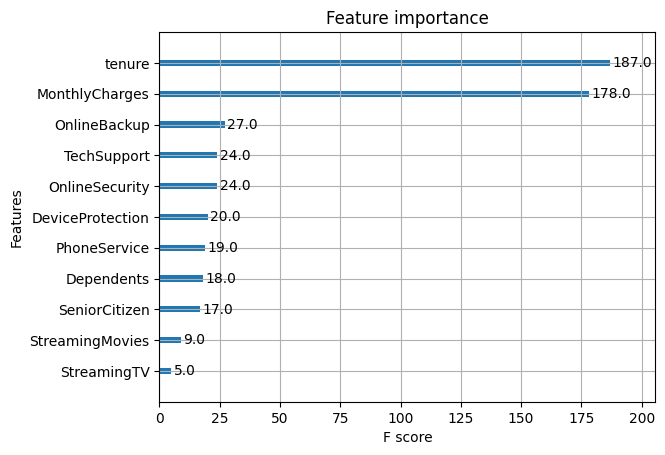

In [33]:
# Calculating feature importance
from xgboost import plot_importance
plot_importance(opt.best_estimator_.steps[1][1])